# Simple LSTM Classifier for Radarly Sentiment Analysis

In [113]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from typing import List

In [4]:
%load_ext watermark

In [101]:
%watermark  --packages tensorflow,pandas,matplotlib

tensorflow: 2.13.1
pandas    : 2.0.3
matplotlib: 3.7.5



## Load the data

In [36]:
df_train=pd.read_csv("../data/twitter_training.csv")
df_test=pd.read_csv("../data/twitter_validation.csv")

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [37]:
df_train.columns = df_test.columns = ['ID', 'entity','sentiment','content']

In [38]:
df_train.head(10)

,ID,entity,sentiment,content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [39]:
df_train.sentiment.value_counts(normalize=True)

sentiment
Negative      0.302156
Positive      0.279127
Neutral       0.244719
Irrelevant    0.173998
Name: proportion, dtype: float64

In [40]:
df_train.entity.value_counts(normalize=True)

entity
MaddenNFL                            0.032124
LeagueOfLegends                      0.032124
CallOfDuty                           0.032110
Verizon                              0.031962
TomClancysRainbowSix                 0.031948
Facebook                             0.031921
Microsoft                            0.031908
Dota2                                0.031881
WorldOfCraft                         0.031854
ApexLegends                          0.031799
NBA2K                                0.031664
CallOfDutyBlackopsColdWar            0.031664
FIFA                                 0.031408
johnson&johnson                      0.031408
TomClancysGhostRecon                 0.031367
Battlefield                          0.031299
Overwatch                            0.031299
GrandTheftAuto(GTA)                  0.030989
HomeDepot                            0.030975
PlayStation5(PS5)                    0.030962
Hearthstone                          0.030894
CS-GO                      

Look at a couple of examples of Positive & Negative reviews

In [41]:
df_train.query("sentiment == 'Positive'").sample(10)

,ID,entity,sentiment,content
72566,8831,Nvidia,Positive,Better performance than anything wrong
34118,6659,Fortnite,Positive,I like my meals with a big round of Fortnite.
36331,8235,Microsoft,Positive,"After 10 years without trying it, I set it up...."
57057,11388,TomClancysRainbowSix,Positive,I'm loving seeing all that the R6 driving and ...
47189,5697,HomeDepot,Positive,"I’m t h r i v i n g, thanks."
22805,4308,CS-GO,Positive,Help me win this awesome CS:GO giveaway from I...
2773,1682,CallOfDutyBlackopsColdWar,Positive,who tryna buy me this shit im willing to do an...
10463,13001,Xbox(Xseries),Positive,I'm extremely happy to upgrade to the Xbox Ser...
69231,3860,Cyberpunk2077,Positive,Who needs AI? A few precisely programmed text ...
49829,6155,FIFA,Positive,Had the most fun on FIFA since launch. Watchin...


In [42]:
df_train.query("sentiment == 'Negative'").sample(10)

,ID,entity,sentiment,content
42429,10079,PlayerUnknownsBattlegrounds(PUBG),Negative,Miss U S Pubg....
71696,11082,TomClancysGhostRecon,Negative,RhandlerR Why before the update I don't have l...
65570,6829,johnson&johnson,Negative,Are they infecting everyone with Venom Powder?
2579,1650,CallOfDutyBlackopsColdWar,Negative,Call Of Duty: Black Ops Cold War beta cheats a...
63539,7690,MaddenNFL,Negative,@EAMaddenNFL i don't know how you guys still m...
45656,11837,Verizon,Negative,Idk how people across Laredo say that @Verizon...
39258,5539,Hearthstone,Negative,Holy shit. Arena sucks now. Brings back all th...
58782,3277,Facebook,Negative,All my success in the past has come from peopl...
39639,1205,Battlefield,Negative,"In multiplayer mode, I can't see even any one ..."
35696,8129,Microsoft,Negative,Today I found out that Windows' Cortana actual...


Clean the data

## Create a simple model

We map the outputs to integers, maybe `Neutral` and `Irrelevant` could be merged in one class ?

In [60]:
sentiment_to_target = {'Positive': 2, 'Neutral': 1, 'Negative': 0, 'Irrelevant': 3}
df_train['Target'] = df_train['sentiment'].map(sentiment_to_target)
df_test['Target'] = df_test['sentiment'].map(sentiment_to_target)

In [61]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['content'].values, df_train['Target'].values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test['content'].values, df_test['Target'].values))

To handle text content, we use the `tf.keras.layers.TextVectorization`.<br>

This layer will accept a string and maps text features to integer sequences. We need to be careful when initializing the layer to pass only the vocabulary of the training dataset.

Quick example below :

```python
>>>layer = tf.keras.layers.TextVectorization(output_sequence_length=5)
>>>layer.adapt(['I like pizza', 'do you like fries'])
>>>layer(['I want pizza and fries'])
<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[5, 1, 4, 1, 6, 0]])>
>>>{i: v for i, v in enumerate(layer.get_vocabulary())}
{0: '',
 1: '[UNK]',
 2: 'like',
 3: 'you',
 4: 'pizza',
 5: 'i',
 6: 'fries',
 7: 'do'}
   
```

Token 0 is reserved for padding
Token 1 is reserved for out-of-vocabulary tokens

In [62]:
for x, y in train_ds.batch(1).take(1):
    print(x, y)

tf.Tensor([b'I am coming to the borders and I will kill you all,'], shape=(1,), dtype=string) tf.Tensor([2], shape=(1,), dtype=int64)


In [87]:
class LSTMClassification(tf.keras.Model):
    def __init__(self, text: List):
        super().__init__()
        
        # We create a text vectorization layer of max length 100, meaning any longer string will be cut.
        # Shorter strings will be padded
        self.text_vectorizer = tf.keras.layers.TextVectorization(
            output_sequence_length=100
        )
        print("Fitting vocabulary in text vectorization layer")
        self.text_vectorizer.adapt(text)
        
        # We use embeddings with zero masking
        self.embedding = tf.keras.layers.Embedding(
            input_dim=len(self.text_vectorizer.get_vocabulary()),
            output_dim=64,
            mask_zero=True
        )
        
        # Bi-directional LSTM
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
        
        self.dense = tf.keras.layers.Dense(256)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.out = tf.keras.layers.Dense(4, activation='softmax')

    def call(self, inputs):
        x = self.text_vectorizer(inputs)
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense(x)
        x = self.dropout(x)
        return self.out(x)

    
model = LSTMClassification(df_train['content'])

Fitting vocabulary in text vectorization layer


## Train it !

In [90]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [91]:
batched_train = train_ds.batch(128).prefetch(128)
batched_test = test_ds.batch(128).prefetch(128)

history = model.fit(
    batched_train, 
    epochs=10,
    validation_data=batched_test
)

Epoch 1/10
579/579 [==============================] - 145s 226ms/step - loss: 1.3623 - accuracy: 0.3222 - val_loss: 1.3124 - val_accuracy: 0.3884
Epoch 2/10
579/579 [==============================] - 120s 208ms/step - loss: 1.1852 - accuracy: 0.4982 - val_loss: 0.9614 - val_accuracy: 0.6276
Epoch 3/10
579/579 [==============================] - 123s 213ms/step - loss: 0.9825 - accuracy: 0.5977 - val_loss: 0.7834 - val_accuracy: 0.6827
Epoch 4/10
579/579 [==============================] - 124s 213ms/step - loss: 0.8319 - accuracy: 0.6660 - val_loss: 0.6399 - val_accuracy: 0.7357
Epoch 5/10
579/579 [==============================] - 129s 223ms/step - loss: 0.6885 - accuracy: 0.7272 - val_loss: 0.5276 - val_accuracy: 0.7808
Epoch 6/10
579/579 [==============================] - 127s 219ms/step - loss: 0.5583 - accuracy: 0.7867 - val_loss: 0.4254 - val_accuracy: 0.8539
Epoch 7/10
579/579 [==============================] - 148s 256ms/step - loss: 0.4499 - accuracy: 0.8338 - val_loss: 0.3657 -

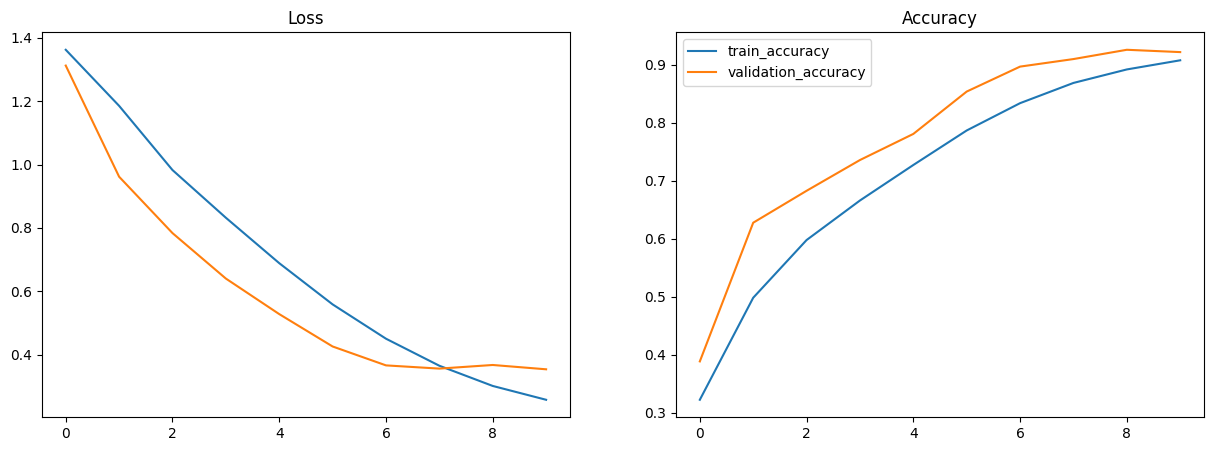

In [108]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(history.history['loss'], label='train_loss')
ax[0].plot(history.history['val_loss'], label='validation_loss')
ax[1].plot(history.history['accuracy'], label='train_accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation_accuracy')
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
plt.legend()

In [127]:
reverse_labels = {v: k for k, v in sentiment_to_target.items()}

def predict_sentence(s):
    y = model.predict(s)
    for n, x in enumerate(y[0]):
        print(f"{reverse_labels[n]}: {100*x:.2f}%")
    

In [128]:
predict_sentence(['I like my meals with a big mac'])

1/1 [==============================] - 0s 35ms/step
Negative: 0.77%
Neutral: 0.84%
Positive: 98.24%
Irrelevant: 0.15%


In [130]:
predict_sentence(['I hate when someone eats my big mac'])

1/1 [==============================] - 0s 40ms/step
Negative: 3.65%
Neutral: 85.97%
Positive: 1.34%
Irrelevant: 9.03%


In [131]:
predict_sentence(['Windows 95 really sucks'])

1/1 [==============================] - 0s 40ms/step
Negative: 99.96%
Neutral: 0.04%
Positive: 0.00%
Irrelevant: 0.00%


In [133]:
predict_sentence(['I am both happy and angry'])

1/1 [==============================] - 0s 152ms/step
Negative: 17.27%
Neutral: 5.53%
Positive: 73.70%
Irrelevant: 3.50%
